This notebook is meant to run on WSL2, hence the directml usage.

Architectures to try:

Branch 1:
- CNN full raster with voxel prediction. Transform TBV to voxel count taking into account the total volume of the raster and the dimensions of each original voxel.
- LSTM of with final TBV prediction. No pretrain.
- LSTM of with final TBV prediction. ResNet.

Branch 2: 
- With raw data, predicting voxel count.
- With histogram (3D histogram or 2D histogram)

Branch 3:
- Without age.
- With age prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import nrrd
import torch
import torch.nn as nn

from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from torch.utils.data import Dataset, DataLoader
import torch_directml as tdml

print(f'Available devices: {tdml.device_count()}')
print(f'Current device: {tdml.device()}')
dml = tdml.device()


/home/daru/code/tbv/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Available devices: 1
Current device: privateuseone:0


In [2]:
class RasterDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir

        raw_labels = [(*(os.path.splitext(file)[0].split("_")[1:-1]), file) for file in os.listdir(data_dir)]

        self.labels = pd.DataFrame(data=raw_labels, columns=["pid", "age", "tbv", "filename"])
        self.labels[["age", "tbv"]] = self.labels[["age", "tbv"]].astype(float)

        self.age_minmax = MinMaxScaler()
        self.tbv_minmax = MinMaxScaler()
        self.age_std = StandardScaler()
        self.tbv_std = StandardScaler()

        self.labels[["age"]] = self.age_minmax.fit_transform(self.labels[["age"]])
        self.labels[["tbv"]] = self.tbv_minmax.fit_transform(self.labels[["tbv"]])
        self.labels[["age"]] = self.age_std.fit_transform(self.labels[["age"]])
        self.labels[["tbv"]] = self.tbv_std.fit_transform(self.labels[["tbv"]])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        entry = self.labels.iloc[idx]
        raster = nrrd.read(os.path.join(self.data_dir, entry["filename"]))[0]
        raster = (raster - np.mean(raster)) / np.std(raster) # Standardize the data

        return {"pid": entry["pid"], "age": entry["age"], "tbv": entry["tbv"], "raster": raster}

    def get_unique_pids(self):
        return self.labels["pid"].unique()
    
    def get_indices_from_pids(self, pids):
        return self.labels[self.labels["pid"].isin(pids)].index
        
class EarlyStopper:
    def __init__(self, patience=25, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model=None):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            if model: self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            if model: self.save_checkpoint(val_loss, model)
            self.counter = 0
        
        return self.early_stop

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [3]:
def train(model, criterion, optimizer, tr_dataloader, val_dataloader, early_stopper, num_epochs, trace_func=print):
    train_loss_list = pd.Series(dtype=np.float32)
    val_loss_list = pd.Series(dtype=np.float32)

    for epoch in range(num_epochs):
        training_loss = 0.
        
        model.train()
        for i, data in enumerate(tr_dataloader):
            rasters = data["raster"].float().unsqueeze(1).to(dml)
            tbvs = data["tbv"].float().to(dml)

            optimizer.zero_grad()

            predictions = model(rasters).squeeze()
            loss = criterion(predictions, tbvs)

            loss.backward()
            optimizer.step()

            training_loss += loss.item()

            if (i+1) % 10 == 0:
                trace_func(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(tr_dataloader)}], Loss: {loss.item():.4f}              ", end="\r")

        validation_loss = 0.
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_dataloader):
                rasters = data["raster"].float().unsqueeze(1).to(dml)
                tbvs = data["tbv"].float().to(dml)

                predictions = model(rasters).squeeze()
                loss = criterion(predictions, tbvs)

                validation_loss += loss.item()

        train_loss = training_loss/len(tr_dataloader)
        val_loss = validation_loss/len(val_dataloader)
        train_loss_list.at[epoch] = train_loss
        val_loss_list.at[epoch] = val_loss

        trace_func(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}               ")
        if early_stopper(validation_loss, model):
            break
    
    return train_loss_list, val_loss_list

def get_unscaled_loss(model, criterion, dataloader, dataset):
    all_diffs = []
    for i, data in enumerate(dataloader):
        rasters = data["raster"].float().unsqueeze(1)
        tbvs = data["tbv"].float()

        predictions = model(rasters).squeeze().cpu()
        predictions = predictions.detach().numpy().reshape(-1, 1)
        tbvs = tbvs.detach().numpy().reshape(-1, 1)
        
        # Revert the normalization and standardization
        predictions = dataset.tbv_std.inverse_transform(predictions)
        predictions = dataset.tbv_minmax.inverse_transform(predictions)
        tbvs = dataset.tbv_std.inverse_transform(tbvs)
        tbvs = dataset.tbv_minmax.inverse_transform(tbvs)

        all_diffs.append(np.abs(predictions - tbvs))

    all_diffs = np.concatenate(all_diffs)
    
    avg_diff = np.mean(all_diffs)
    std_diff = np.std(all_diffs)

    return avg_diff, std_diff

def cross_validator(model, dataset, k_fold=5, num_epochs=100, patience=25, optimizer_class=torch.optim.Adam, criterion_class=nn.MSELoss, learning_rate=0.001, weight_decay = 0.00001, batch_size=32, data_workers=4, verbose=False, trace_func=print):
    # Save model to reset it after each fold
    torch.save(model.state_dict(), "base_weights.pt")

    train_score = pd.Series(dtype=np.float32)
    val_score = pd.Series(dtype=np.float32)
    unscaled_loss = pd.Series(dtype=np.float32)
    
    unique_pids = dataset.get_unique_pids()
    total_pids = len(unique_pids)
    fraction = 1/k_fold
    seg = int(total_pids*fraction)
    
    # tr:train, val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
    # index: [trll,trlr],[vall,valr],[trrl,trrr]
    for i in range(k_fold):
        trace_func(f"Fold {i+1}/{k_fold}")

        model.load_state_dict(torch.load("base_weights.pt"))

        criterion = criterion_class()
        optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        early_stopper = EarlyStopper(patience=patience, verbose=verbose, path="best_weights.pt", trace_func=trace_func)

        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_pids
        
        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))
        
        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))

        train_indices = dataset.get_indices_from_pids(unique_pids[train_indices])
        val_indices = dataset.get_indices_from_pids(unique_pids[val_indices])

        train_set = torch.utils.data.dataset.Subset(dataset, train_indices)
        val_set = torch.utils.data.dataset.Subset(dataset, val_indices)

        train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=data_workers)
        test_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=data_workers)
        
        train_loss_list, val_loss_list = train(model, criterion, optimizer, train_dataloader, test_dataloader, early_stopper, num_epochs, trace_func)
        
        model.load_state_dict(torch.load("best_weights.pt"))

        train_score.at[i] = train_loss_list
        val_score.at[i] = val_loss_list
        unscaled_loss.at[i] = get_unscaled_loss(model, criterion, test_dataloader, dataset)
    
    os.remove("base_weights.pt")
    os.remove("best_weights.pt")
    
    return train_score, val_score, unscaled_loss

# Pytorch Models

In [4]:
class Triplanar_first_no_age_0(nn.Module):
    def __init__(self):
        super(Triplanar_first_no_age_0, self).__init__()

        # First layer is triplanar as used in S3PNet:
        # https://www.sciencedirect.com/science/article/pii/S1077314219301791

        self.trpl = nn.Sequential( # 128x128x128 -> 32x40x40
            nn.Conv2d(128, 32, kernel_size=9, stride=3, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.conv1 = nn.Sequential( # 96x40x40 -> 192x10x10
            nn.Conv2d(96, 192, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential( # 192x10x10 -> 384x5x5
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv3 = nn.Sequential( # 384x5x5 -> 768x3x3
            nn.Conv2d(384, 768, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(768),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv4 = nn.Sequential( # 768x3x3 -> 1536x1x1
            nn.Conv2d(768, 1536, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1536),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear = nn.Sequential(
            nn.Linear(1536, 768),
            nn.ReLU(),
            nn.Linear(768, 1)
        )

    def forward(self, base):
        base = base.squeeze().float().to(dml)

        xy = self.trpl(base)
        yz = self.trpl(torch.transpose(base, 2, 1))
        xz = self.trpl(torch.transpose(base, 1, 3))

        x = self.conv1(torch.cat((xy, yz, xz), dim=1))
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return self.linear(x.squeeze())

In [5]:
class Triplanar_first_no_age_1(nn.Module):
    def __init__(self):
        super(Triplanar_first_no_age_1, self).__init__()

        # First layer is triplanar as used in S3PNet:
        # https://www.sciencedirect.com/science/article/pii/S1077314219301791

        self.trpl = nn.Sequential( # 128x128x128 -> 32x40x40
            nn.Conv2d(128, 32, kernel_size=9, stride=3, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.conv1 = nn.Sequential( # 96x40x40 -> 192x10x10
            nn.Conv2d(96, 192, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential( # 192x10x10 -> 384x5x5
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv3 = nn.Sequential( # 384x5x5 -> 768x3x3
            nn.Conv2d(384, 768, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(768),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv4 = nn.Sequential( # 768x3x3 -> 1536x1x1
            nn.Conv2d(768, 1536, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1536),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear = nn.Sequential(
            nn.Linear(1536, 768),
            nn.ReLU(),
            nn.Linear(768, 1)
        )

    def forward(self, base):
        base = base.squeeze().float().to(dml)

        xy = self.trpl(base)
        yz = self.trpl(torch.transpose(base, 2, 1))
        xz = self.trpl(torch.transpose(base, 1, 3))

        x = self.conv1(torch.cat((xy, yz, xz), dim=1))
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return self.linear(x.squeeze())

In [6]:
class Full_2d_no_age_0(nn.Module):
    def __init__(self):
        super(Full_2d_no_age_0, self).__init__()

        self.conv0 = nn.Sequential( # 128x128x128 -> 256x32x32
            nn.Conv2d(128, 256, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv1 = nn.Sequential( # 256x32x32 -> 512x16x16
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential( # 512x16x16 -> 1024x8x8
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv3 = nn.Sequential( # 1024x8x8 -> 2048x4x4
            nn.Conv2d(1024, 2048, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(2048),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv4 = nn.Sequential( # 2048x4x4 -> 4096x2x2
            nn.Conv2d(2048, 4096, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4096),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv5 = nn.Sequential( # 4096x2x2 -> 8192x1x1
            nn.Conv2d(4096, 8192, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear = nn.Sequential(
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1)
        )

    def forward(self, base):
        base = base.squeeze().float().to(dml)

        # View from y axis (Coronal, as this is the clearest view)
        base = torch.transpose(base, 2, 1)

        x = self.conv0(base)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)
        return self.linear(x)

## Model cross validated training

In [7]:
dataset = RasterDataset(data_dir="../aug_dataset")
model = Full_2d_no_age_0().to(dml)

tr_score, val_score, unscaled_loss = cross_validator(
    model, dataset, k_fold=6, num_epochs=250, patience=20, 
    optimizer_class=torch.optim.Adam, criterion_class=nn.MSELoss, 
    learning_rate=0.0001, weight_decay=0.0, batch_size=16, data_workers=2,
    verbose=True, trace_func=print
)


Fold 1/6


/home/daru/code/tbv/venv/lib/python3.8/site-packages/torch/autograd/__init__.py:197: UserWarning: HIP initialization: Unexpected error from hipGetDeviceCount(). Did you run some cuda functions before calling NumHipDevices() that might have already set an error? Error 101: hipErrorInvalidDevice (Triggered internally at ../c10/hip/HIPFunctions.cpp:110.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/250], Training Loss: 1.5369, Validation Loss: 1.5755               
Validation loss decreased (inf --> 118.164002).  Saving model ...
Epoch [2/250], Training Loss: 0.8173, Validation Loss: 1.5949               
EarlyStopping counter: 1 out of 20
Epoch [3/250], Training Loss: 0.7095, Validation Loss: 1.6044               
EarlyStopping counter: 2 out of 20
Epoch [4/250], Training Loss: 0.6095, Validation Loss: 0.9405               
Validation loss decreased (118.164002 --> 70.535996).  Saving model ...
Epoch [5/250], Training Loss: 0.4633, Validation Loss: 1.0965               
EarlyStopping counter: 1 out of 20
Epoch [6/250], Training Loss: 0.3647, Validation Loss: 1.2716               
EarlyStopping counter: 2 out of 20
Epoch [7/250], Training Loss: 0.2891, Validation Loss: 1.0925               
EarlyStopping counter: 3 out of 20
Epoch [8/250], Training Loss: 0.2327, Validation Loss: 1.0490               
EarlyStopping counter: 4 out of 20
Epoch [9/250], Training Loss: 0.1840

/tmp/ipykernel_193/1145575098.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


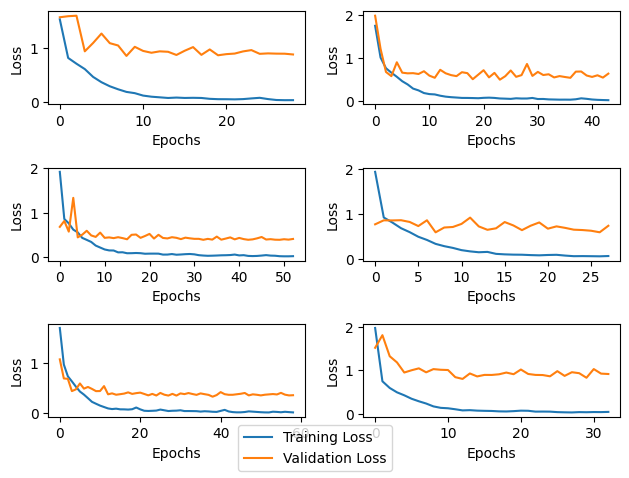

In [8]:

figure, axis = plt.subplots(3, 2)
for i in range(3):
    for j in range(2):
        axis[i][j].plot(tr_score[i*2+j], label="Training Loss", linewidth=1.5)
        axis[i][j].plot(val_score[i*2+j], label="Validation Loss", linewidth=1.5)
        axis[i][j].set_xlabel("Epochs")
        axis[i][j].set_ylabel("Loss")

handles, labels = axis[i][j].get_legend_handles_labels()
figure.legend(handles, labels, loc='lower center')

figure.tight_layout()
figure.show()

Text(0, 0.5, 'TBV Loss')

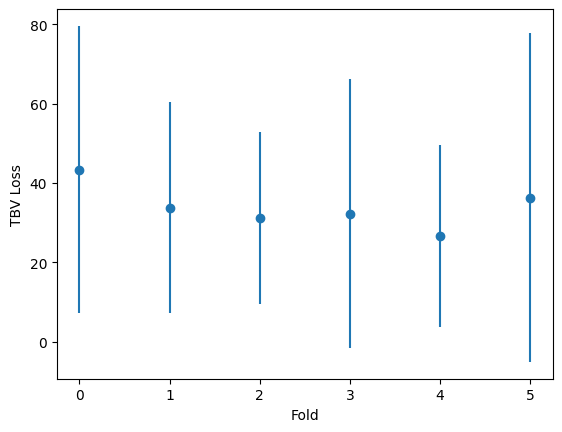

In [9]:
unscaled_loss = pd.DataFrame(unscaled_loss.tolist(), columns=['avg','std'], index=unscaled_loss.index)
avg_loss = unscaled_loss['avg']
std_loss = unscaled_loss['std']

plt.errorbar(x=range(6), y=avg_loss, yerr=std_loss, fmt='o')
plt.xlabel("Fold")
plt.ylabel("TBV Loss")

In [10]:
display(unscaled_loss)

,avg,std
0,43.358246,36.209705
1,33.782776,26.561201
2,31.151865,21.578844
3,32.257938,34.001205
4,26.637047,22.976866
5,36.270725,41.414104
